In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import OneHotEncoder

In [2]:
#clean_data = pd.read_csv("../data/data1/clean_data_full.csv")
clean_data = pd.read_csv("../data/data1/clean_data_short.csv")

In [3]:
clean_data = clean_data.drop(columns = ['Unnamed: 0'])

In [4]:
clean_data

,age,gender,x,y,dx,dy,img_path
0,5,0,1912,905,1224,1224,../data/data1/faces/30601258@N03/coarse_tilt_a...
1,4,1,101,56,740,740,../data/data1/faces/30601258@N03/coarse_tilt_a...
2,4,0,693,247,720,720,../data/data1/faces/30601258@N03/coarse_tilt_a...
3,4,0,1039,1432,624,625,../data/data1/faces/30601258@N03/coarse_tilt_a...
4,4,1,223,58,780,781,../data/data1/faces/30601258@N03/coarse_tilt_a...
...,...,...,...,...,...,...,...
9806,6,1,913,621,189,187,../data/data1/faces/101515718@N03/coarse_tilt_...
9807,4,1,0,404,741,769,../data/data1/faces/101515718@N03/coarse_tilt_...
9808,4,0,718,748,492,492,../data/data1/faces/101515718@N03/coarse_tilt_...
9809,4,0,950,0,692,687,../data/data1/faces/101515718@N03/coarse_tilt_...


## Convert images to array 

In [5]:
X = clean_data[['img_path']]
y = clean_data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((128, 128))   # Resize the image
    data = np.asarray(image) 
    train_images.append(data)

print('train done...')

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((128, 128))  # Resize the image
    data = np.asarray(image) 
    test_images.append(data)

print('normalizing...')
train_images = np.asarray(train_images) / 255
test_images = np.asarray(test_images) / 255

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train data shape (6867, 1)
Test data shape (2944, 1)
train done...
normalizing...
Train images shape (6867, 128, 128, 3)
Test images shape (2944, 128, 128, 3)


# Convert Images generator

## Age model 

In [7]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3),padding='same', activation='relu', input_shape=(128, 128, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu'),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=100, validation_data=(test_images, y_test), callbacks=[callback])
#history = model.fit(train_images, y_train, epochs=500, validation_data=(test_images, y_test), callbacks=[callback])
model.save('../data/age_model_16_11_2021.h5')

test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

2021-11-16 11:51:50.106547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1350107136 exceeds 10% of free system memory.
2021-11-16 11:51:50.857861: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1350107136 exceeds 10% of free system memory.


Epoch 1/100


2021-11-16 11:51:52.234220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2021-11-16 11:51:52.608980: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


215/215 [==============================] - ETA: 0s - loss: 2.0042 - accuracy: 0.2126

2021-11-16 11:52:03.460471: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 578813952 exceeds 10% of free system memory.
2021-11-16 11:52:03.762000: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 578813952 exceeds 10% of free system memory.


215/215 [==============================] - 13s 50ms/step - loss: 2.0042 - accuracy: 0.2126 - val_loss: 1.9798 - val_accuracy: 0.2038
Epoch 2/100
215/215 [==============================] - 9s 44ms/step - loss: 1.8998 - accuracy: 0.2559 - val_loss: 1.8988 - val_accuracy: 0.2629
Epoch 3/100
215/215 [==============================] - 9s 44ms/step - loss: 1.8071 - accuracy: 0.2946 - val_loss: 1.7745 - val_accuracy: 0.3230
Epoch 4/100
215/215 [==============================] - 9s 44ms/step - loss: 1.6880 - accuracy: 0.3515 - val_loss: 1.6653 - val_accuracy: 0.3733
Epoch 5/100
215/215 [==============================] - 9s 44ms/step - loss: 1.5296 - accuracy: 0.4168 - val_loss: 1.5877 - val_accuracy: 0.3998
Epoch 6/100
215/215 [==============================] - 10s 45ms/step - loss: 1.3041 - accuracy: 0.5120 - val_loss: 1.5385 - val_accuracy: 0.4243
Epoch 7/100
215/215 [==============================] - 10s 44ms/step - loss: 0.9956 - accuracy: 0.6406 - val_loss: 1.6323 - val_accuracy: 0.4287
E

2021-11-16 11:55:27.465455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 578813952 exceeds 10% of free system memory.


92/92 - 1s - loss: 3.5005 - accuracy: 0.4620 - 796ms/epoch - 9ms/step
0.46195653080940247


## losses 

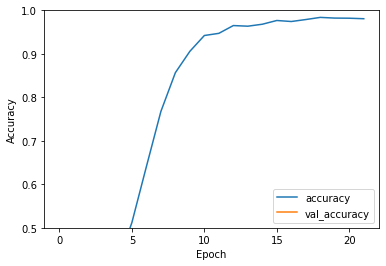

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

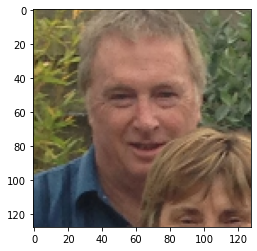

In [10]:
image_path = X_test.img_path[1078]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) / 255.0
plt.imshow(image)
plt.show()

In [11]:
X_test.img_path[1078]

'../data/data1/faces/9017386@N06/coarse_tilt_aligned_face.216.10770601955_e7ecc9ac58_o.jpg'

In [12]:
image = np.expand_dims(image, 0)
prediction = model.predict(image)

In [13]:
prediction 

array([[2.3970069e-05, 4.4040975e-05, 5.0865574e-04, 9.3385315e-05,
        2.0920911e-03, 3.1918671e-02, 9.6447510e-01, 8.4403739e-04]],
      dtype=float32)

In [14]:
index = np.argmax(prediction)
decoding = {0:'0-2', 1:'4-6', 2:'8-13',3:'15-20',4:'25-32',5:'38-43',6:'48-53',7:'60+'}

print('[+] prediction is :', decoding[index]) 



[+] prediction is : 48-53


In [15]:
predictions = model.predict(test_images)

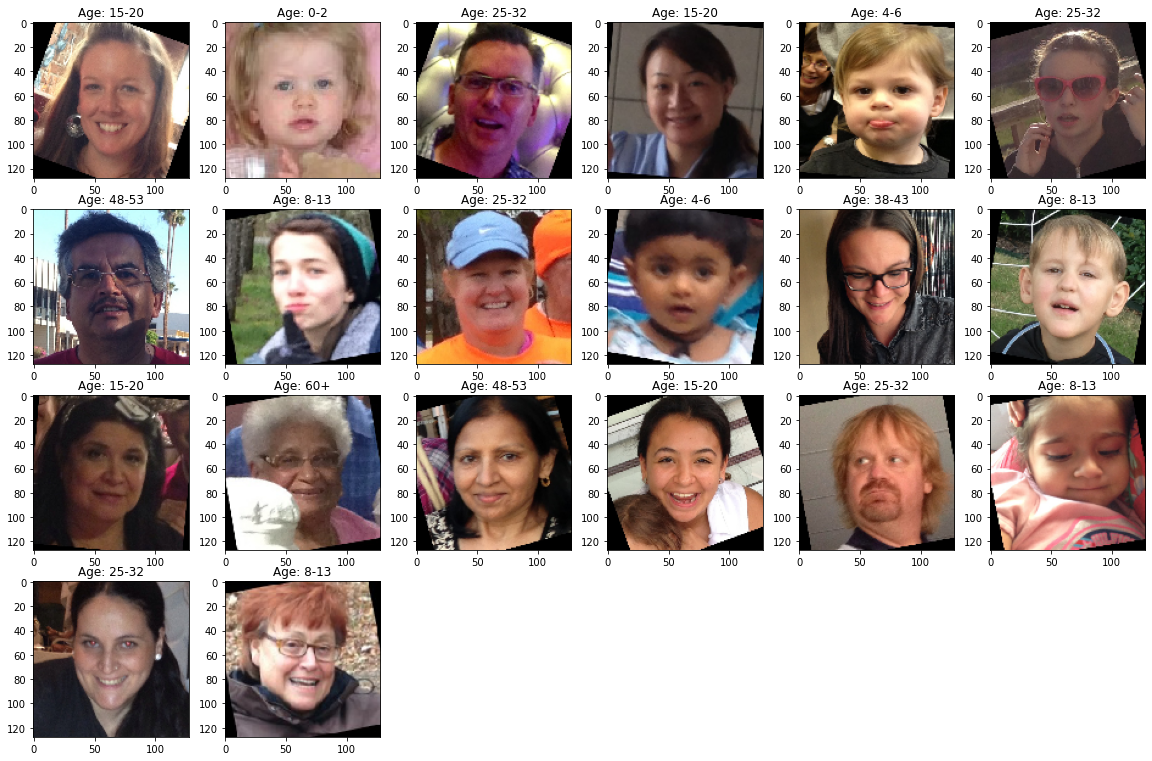

In [16]:
plt.figure(figsize=(20,20))
for row in range(20):
    plt.subplot(6,6,row+1)
    index = np.argmax(predictions[row])
    decoding = {0:'0-2', 1:'4-6', 2:'8-13',3:'15-20',4:'25-32',5:'38-43',6:'48-53',7:'60+'}
    plt.title('Age: ' + decoding[index] )
    plt.imshow(test_images[row])